extended_yale_SVM&KNN

## <center>Face Recognition<center>

Subset of the Extended Yale Face database B(11/12/13/15/16/17/18) contains 4166 images of 7 human subjects under 9 poses and 64 illumination conditions

try 3 different Face-recognition approaches: KNN, PCA, Convolutional Neural Network(CNN)
    
to check their advantages and disadvantages under different scenario

### <center> Load Data<center>

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
import os,sys
from sklearn.model_selection import train_test_split

import logging
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from time import time
from sklearn.pipeline import Pipeline


In [3]:
from PIL import Image
import numpy as np
import glob


# Min's Link
path = '/Users/minfang/Documents/ExtendYale'
def read_images(path, sz=(168,192),occlusion = False): 
    t0 = time() # time reading images
    c=0 # count of read images
    
    # y to store subject number of images read
    y = [] 
    # Images are resized to 640x480
    # x to store all image data
    x = np.empty([1, 32256]) 
    for dirname , dirnames , filenames in os.walk(path):
        # loop all directories, sub-dir, files to read images
        # in data folder of this project, only 1st dirnames is valid, others are empty list (no subfolder)
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                # read files start with 'yale'
                # eclude windows hidden files of 'desktop.ini'
                if filename[:4] != 'yale':
                    continue
                
                # for files start with 'yale'
                # 1. read image
                # 2. convert images from RGB to L(color to black/white)
                # In this project, all images are greyscale images, run this step in case of exceptions
                # 3. resize image to 168 X 192
                # In this project, all images are 168 X 192, run this step in case of exceptions
                # 4. read images to matrix (ndarray)
                # 5. normalize image matrix
                # 6. flatten image ndarray (2-d to 1-d)
                # 7. store image ndarray to data (x)
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.ANTIALIAS)
                    im  = np.asarray(im, dtype=np.uint8)
                    im.flags.writeable = True # set ndarray as writeable. not read-only
                    
                    # Normalization
                    im = (im - im.mean())/im.std()

                    # Set occlusion area, not useful in this project. 
                    # Just for fun and possible applications in extending projects
                    if occlusion:
                        im[30:60,10:150]=im.min()
                        im[70:100,60:100]=im.min()
                    
                    # Convert 2-d ndarray images to 1-d array by rows through ndarray.ravel()
                    # append image array to x
                    # first element is empty array
                    x = np.vstack((x,im.ravel()))
  
                    # y.append(c)
                    # append image subject number to label data: y
                    y.append(filename[5:7])
                except IOError:
                    #print "I/O error({0}): {1}".format("errno", "strerror") #there is some text files in the path
                    pass
                except:
                    print ("Unexpected error:", sys.exc_info()[0] )
                    raise
            c = c+1
        
    y = np.asarray(y)
    x = x[1:] # Skip the first line which is void
    print("Image read in %0.3fs" % (time() - t0))
    return [x,y]

### <center> train test split<center>

In [4]:
%%time
x,y = read_images(path=path,occlusion=False)

Image read in 1244.691s
CPU times: user 15min 24s, sys: 12min 47s, total: 28min 12s
Wall time: 20min 44s


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [6]:
# check train, test data shape and labels
print("x data  size: ", x.shape[0])
print("y data  size: ", y.shape[0])
print("x_train size: ", x_train.shape[0])
print("y_trian size: ", y_train.shape[0])
print("x_test  size: ", x_test.shape[0])
print("y_test  size: ", y_test.shape[0])

r_unique, r_counts = np.unique(y_train, return_counts=True)
t_unique, t_counts = np.unique(y_test, return_counts=True)

print("\nTrain set labels: ", r_unique)
print("Train set counts: ", r_counts)
print("Test  set labels: ", t_unique)
print("Train set counts: ", t_counts)
print("Test  set counts: ", t_counts)

x data  size:  4095
y data  size:  4095
x_train size:  3685
y_trian size:  3685
x_test  size:  410
y_test  size:  410

Train set labels:  ['11' '12' '13' '15' '16' '17' '18']
Train set counts:  [527 537 534 523 527 515 522]
Test  set labels:  ['11' '12' '13' '15' '16' '17' '18']
Train set counts:  [58 48 51 62 58 70 63]
Test  set counts:  [58 48 51 62 58 70 63]


In [7]:
train_size = pd.DataFrame({'label':r_unique,'train_size':r_counts,}).T
train_size

,0,1,2,3,4,5,6
label,11,12,13,15,16,17,18
train_size,527,537,534,523,527,515,522


In [8]:
test_size = pd.DataFrame({'label':t_unique,'train_size':t_counts,}).T
test_size

,0,1,2,3,4,5,6
label,11,12,13,15,16,17,18
train_size,58,48,51,62,58,70,63


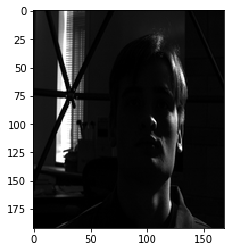

<Figure size 432x288 with 0 Axes>

In [9]:
#print(x_test[10].reshape(168, 192))
im0 = x[0].reshape(192, 168)
plt.imshow(im0, cmap = plt.get_cmap("gray"))
plt.show()
plt.clf()